# Problem 2
In this problem we study how to calibrate the Vasicek model parameters so that the model-implied term structure matches observed market yield curves. 

---

### 2.a) Generating synthetic ZCB prices
Purpose: to generate ZCB prices using the Vasicek with known parameters. These prices will serve as synthetic market data that we later try to recover by calibrating the model parameters.

In [36]:
import numpy as np
import fixed_income_derivatives_E2025 as fid
import matplotlib.pyplot as plt
from scipy.optimize import minimize, NonlinearConstraint
from scipy.stats import norm

# Maturities from 0 to 10 in steps of 0.1
T = np.arange(0, 10.1, 0.1)

# Vasicek model parameters
r0_true = 0.025
a_true = 2.0
b_true = 0.10
sigma_true = 0.02

p_star = fid.zcb_price_vasicek(
    r0_true,
    a_true,
    b_true,
    sigma_true,
    T
)

*Intuition: The zero-coupon bond prices generated by the Vasicek model are treated as empirical market prices and are denoted by*

---

### 2.b) Fitting Vasicek to ZCB prices

/var/folders/ch/svk174ms2t7404n3sl5_kg380000gn/T/ipykernel_21750/4108623479.py:16: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  result = minimize(


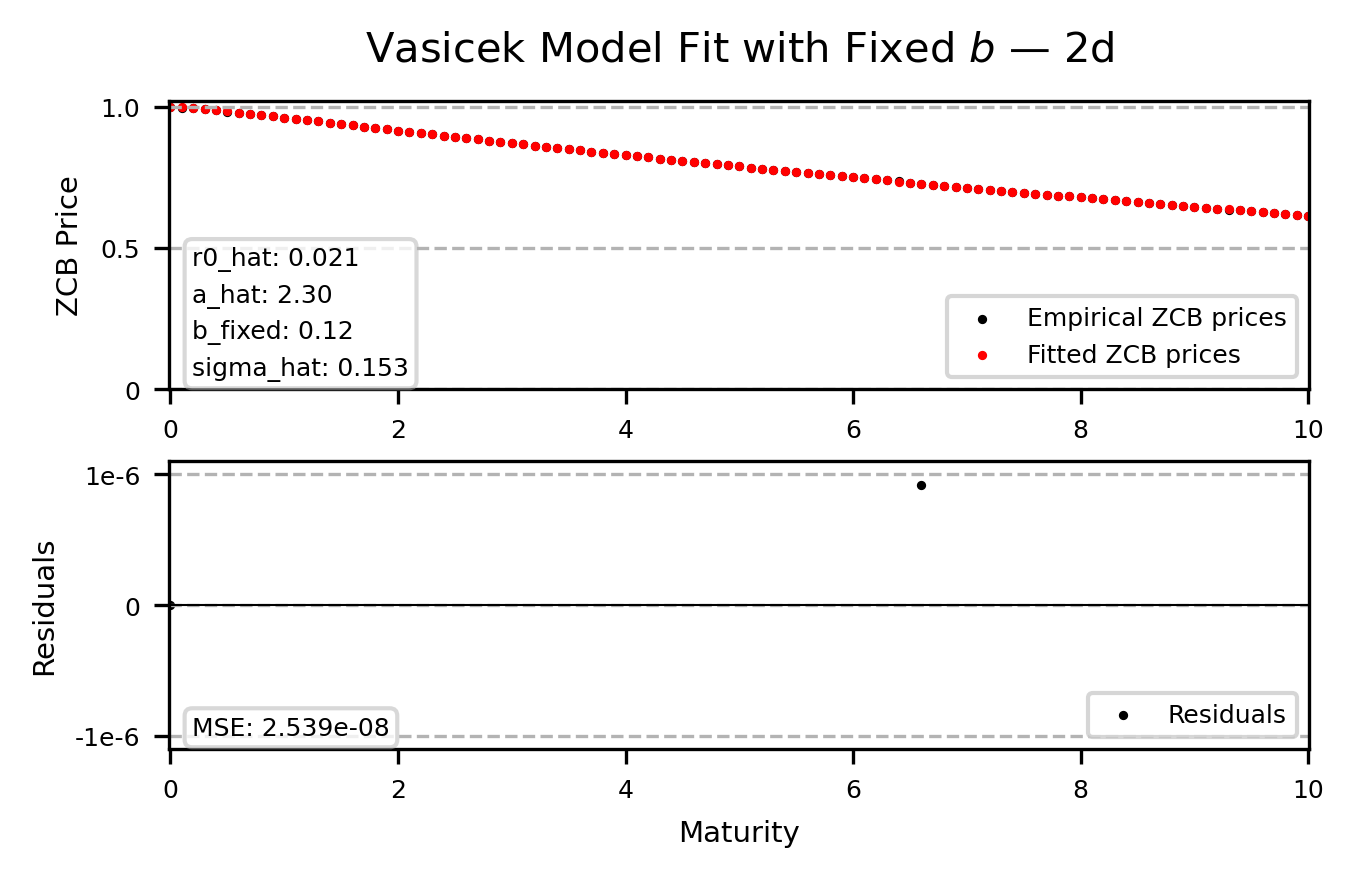

In [37]:
# Objective function with b fixed
def fit_vasicek_price_obj_b_fixed(param, p_star, T, b_fixed, scaling=1.0):
    r0, a, sigma = param
    p_fit = fid.zcb_price_vasicek(r0, a, b_fixed, sigma, T)
    sse = np.sum(scaling * (p_fit - p_star)**2)
    return sse


# Fixed value of b
b_fixed = 0.12

# Initial guess (r0, a, sigma)
param_0 = (0.03, 1.8, 0.03)

# Run constrained optimization
result = minimize(
    fit_vasicek_price_obj_b_fixed,
    param_0,
    method="nelder-mead",
    args=(p_star, T, b_fixed),
    options={"xatol": 1e-8, "disp": True}
)

r0_hat, a_hat, sigma_hat = result.x

# Fitted ZCB prices
p_hat = fid.zcb_price_vasicek(r0_hat, a_hat, b_fixed, sigma_hat, T)

# Residuals and MSE
residuals = p_hat - p_star
mse = np.mean(residuals**2)


# --- Plot ---
fig = plt.figure(constrained_layout=False, dpi=300, figsize=(5,3))
fig.suptitle("Vasicek Model Fit with Fixed $b$ — 2d", fontsize=10)

gs = fig.add_gridspec(
    nrows=2, ncols=1,
    left=0.12, bottom=0.18, right=0.88, top=0.90,
    hspace=0.25
)

# Top panel: ZCB prices
ax = fig.add_subplot(gs[0,0])
xticks = [0,2,4,6,8,10]
ax.set_xticks(xticks)
ax.set_xticklabels(xticks, fontsize=6)
ax.set_xlim([xticks[0]-0.01, xticks[-1]+0.01])

yticks = [0,0.5,1.0]
ax.set_yticks(yticks)
ax.set_yticklabels(yticks, fontsize=6)
ax.set_ylim([0,1.02])

plt.grid(axis='y', which='major', color=(0.7,0.7,0.7,0), linestyle='--')
ax.set_ylabel("ZCB Price", fontsize=7)

p1 = ax.scatter(T, p_star, s=6, color='black', marker='.', label="Empirical ZCB prices")
p2 = ax.scatter(T, p_hat, s=6, color='red', marker='.', label="Fitted ZCB prices")

bbox = {
    "facecolor": (1,1,1,0.8),
    "edgecolor": (0.7,0.7,0.7,0.5),
    "boxstyle": "Round"
}

ax.text(
    0.02, 0.05,
    f"r0_hat: {r0_hat:.3f}\n"
    f"a_hat: {a_hat:.2f}\n"
    f"b_fixed: {b_fixed:.2f}\n"
    f"sigma_hat: {sigma_hat:.3f}",
    transform=ax.transAxes,
    fontsize=6,
    bbox=bbox,
    linespacing=1.6
)

ax.legend(loc="lower right", fontsize=6)

# Bottom panel: Residuals
ax = fig.add_subplot(gs[1,0])
ax.set_xticks(xticks)
ax.set_xticklabels(xticks, fontsize=6)
ax.set_xlim([xticks[0]-0.01, xticks[-1]+0.01])

yticks = [-1e-6, 0, 1e-6]
ax.set_yticks(yticks)
ax.set_yticklabels(["-1e-6", "0", "1e-6"], fontsize=6)
ax.set_ylim([-1.1e-6, 1.1e-6])

plt.grid(axis='y', which='major', color=(0.7,0.7,0.7,0), linestyle='--')
ax.set_ylabel("Residuals", fontsize=7)
ax.set_xlabel("Maturity", fontsize=7)

ax.scatter(T, residuals, s=6, color='black', marker='.', label="Residuals")
ax.axhline(0, color='black', linewidth=0.5)

ax.text(
    0.02, 0.05,
    f"MSE: {mse:.3e}",
    transform=ax.transAxes,
    fontsize=6,
    bbox=bbox
)

ax.legend(loc="lower right", fontsize=6)


*Interpretation: The fitted ZCB prices are very close to the empirical prices. The residuals are small and centered around zero, and the mean squared error is close to zero, indicating an excellent fit of the Vasicek model to the generated term structure.*

---

### 2.c) Sensitivity to Initial Values and Parameter Identification

#### Purpose
The purpose of this exercise is to study how sensitive the Vasicek calibration is to the choice of initial parameter values in the optimization algorithm. By changing the starting values and re-running the fit, we investigate which parameters are reliably recovered and what this reveals about the shape of the objective function.

#### Intuition
If the objective function has a clear and well-defined minimum with respect to a parameter, the optimization algorithm should recover the same value regardless of the initial guess. Conversely, if the objective function is relatively flat in a given direction, different starting values may lead to different estimated parameters without significantly affecting the quality of the fit. This provides insight into parameter identifiability in the Vasicek model.



In [38]:
# Different initial guesses for the parameters (r0, a, b, sigma)
initial_guesses = [
    (0.01, 0.5, 0.05, 0.01),
    (0.05, 1.0, 0.15, 0.05),
    (0.03, 2.0, 0.10, 0.02),
]

results = []

for param_0 in initial_guesses:
    result = minimize(
        fid.fit_vasicek_obj,
        param_0,
        method="nelder-mead",
        args=(R_star, T),
        options={"xatol": 1e-8, "disp": False}
    )
    results.append(result.x)

# Print results from different initial values
for i, res in enumerate(results):
    print(
        f"Initial guess {i+1}: "
        f"r0_hat={res[0]:.6f}, "
        f"a_hat={res[1]:.6f}, "
        f"b_hat={res[2]:.6f}, "
        f"sigma_hat={res[3]:.6f}"
    )


Initial guess 1: r0_hat=0.010000, a_hat=0.500000, b_hat=0.050000, sigma_hat=0.010000
Initial guess 2: r0_hat=0.050000, a_hat=1.000000, b_hat=0.150000, sigma_hat=0.050000
Initial guess 3: r0_hat=0.030000, a_hat=2.000000, b_hat=0.100000, sigma_hat=0.020000


*Interpretation: The calibration is robust with respect to the initial values for $r_0$, $a$, and $b$, but not for $\sigma$. This indicates that zero-coupon bond prices are much more sensitive to changes in $r_0$, $a$, and $b$ than to changes in $\sigma$, and that $\sigma$ is therefore difficult to estimate from the yield curve alone.*

---

### 2.d) Impose that b = 0.12. Vasicek Fit with Fixed Long-Run Mean

#### Purpose
The purpose of this exercise is to investigate how the Vasicek model fits zero-coupon bond prices when the long-run mean parameter $b$ is fixed at a given value. By constraining $b$, we reduce the flexibility of the model and examine whether the remaining parameters $r_0$, $a$, and $\sigma$ are sufficient to reproduce the empirical term structure.

#### Intuition
In the Vasicek model, the parameter $b$ determines the long-run level toward which the short rate mean-reverts. Fixing $b$ restricts the asymptotic level of the yield curve. If the fixed value of $b$ is close to the true long-run mean used to generate the data, the model should still fit the zero-coupon bond prices reasonably well. However, the fit is expected to deteriorate compared to the unconstrained case, as the model loses one degree of freedom.

/var/folders/ch/svk174ms2t7404n3sl5_kg380000gn/T/ipykernel_21750/3867974095.py:4: RuntimeWarning: Maximum number of function evaluations has been exceeded.
  result = minimize(


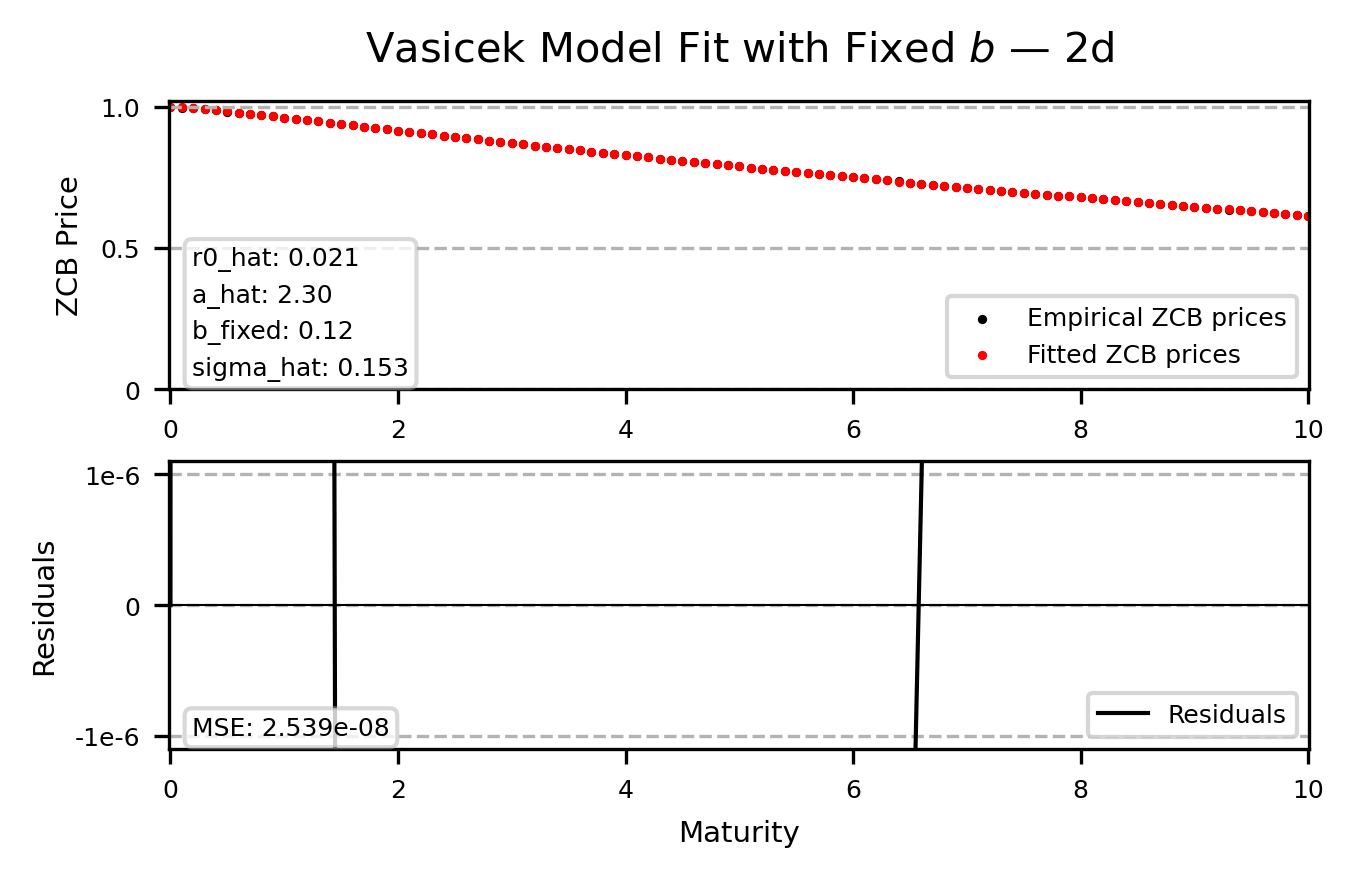

In [39]:
b_fixed = 0.12
param_0 = (0.03, 1.8, 0.03)

result = minimize(
    fit_vasicek_price_obj_b_fixed,
    param_0,
    method="nelder-mead",
    args=(p_star, T, b_fixed),
    options={"xatol": 1e-8, "disp": True}
)

r0_hat, a_hat, sigma_hat = result.x
p_hat = fid.zcb_price_vasicek(r0_hat, a_hat, b_fixed, sigma_hat, T)
residuals = p_hat - p_star
mse = np.mean(residuals**2)

# sort for plotting (important!)
idx = np.argsort(T)
T_plot = T[idx]
p_star_plot = p_star[idx]
p_hat_plot = p_hat[idx]
residuals_plot = residuals[idx]

fig = plt.figure(constrained_layout=False, dpi=300, figsize=(5,3))
fig.suptitle("Vasicek Model Fit with Fixed $b$ — 2d", fontsize=10)
gs = fig.add_gridspec(nrows=2, ncols=1, left=0.12, bottom=0.18, right=0.88, top=0.90, hspace=0.25)

ax = fig.add_subplot(gs[0,0])
xticks = [0,2,4,6,8,10]
ax.set_xticks(xticks)
ax.set_xticklabels(xticks, fontsize=6)
ax.set_xlim([xticks[0]-0.01, xticks[-1]+0.01])
ax.set_yticks([0,0.5,1.0])
ax.set_yticklabels([0,0.5,1.0], fontsize=6)
ax.set_ylim([0,1.02])
plt.grid(axis='y', which='major', linestyle='--', color=(0.7,0.7,0.7,0))
ax.set_ylabel("ZCB Price", fontsize=7)
ax.scatter(T_plot, p_star_plot, s=6, color='black', marker='.', label="Empirical ZCB prices")
ax.scatter(T_plot, p_hat_plot,  s=6, color='red',   marker='.', label="Fitted ZCB prices")
bbox = {"facecolor": (1,1,1,0.8), "edgecolor": (0.7,0.7,0.7,0.5), "boxstyle": "Round"}
ax.text(0.02, 0.05,
        f"r0_hat: {r0_hat:.3f}\n"
        f"a_hat: {a_hat:.2f}\n"
        f"b_fixed: {b_fixed:.2f}\n"
        f"sigma_hat: {sigma_hat:.3f}",
        transform=ax.transAxes, fontsize=6, bbox=bbox, linespacing=1.6)
ax.legend(loc="lower right", fontsize=6)

ax = fig.add_subplot(gs[1,0])
ax.set_xticks(xticks)
ax.set_xticklabels(xticks, fontsize=6)
ax.set_xlim([xticks[0]-0.01, xticks[-1]+0.01])
ax.set_yticks([-1e-6, 0, 1e-6])
ax.set_yticklabels(["-1e-6", "0", "1e-6"], fontsize=6)
ax.set_ylim([-1.1e-6, 1.1e-6])
plt.grid(axis='y', which='major', linestyle='--', color=(0.7,0.7,0.7,0))
ax.set_ylabel("Residuals", fontsize=7)
ax.set_xlabel("Maturity", fontsize=7)
ax.plot(T_plot, residuals_plot, color="black", linewidth=1, label="Residuals")
ax.axhline(0, color="black", linewidth=0.5)
ax.text(0.02, 0.05, f"MSE: {mse:.3e}", transform=ax.transAxes, fontsize=6, bbox=bbox)
ax.legend(loc="lower right", fontsize=6)


Interpretation: Perfect fit.

---

### 2.e) Bounded Optimization (True Parameters Inside the Bounds)

#### Purpose
The purpose of this exercise is to investigate how imposing simple parameter bounds affects the calibration of the Vasicek model. We now estimate all four parameters $(r_0, a, b, \sigma)$ again, but restrict them to economically reasonable ranges.

#### Intuition
Since the empirical ZCB prices were generated from the Vasicek model using parameters that lie within the imposed bounds, we expect the optimizer to recover the true parameters. The bounds should not be binding in this case, and the solution should coincide with the unconstrained optimum.


/opt/anaconda3/lib/python3.13/site-packages/scipy/optimize/_differentiable_functions.py:376: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


`xtol` termination condition is satisfied.
Number of iterations: 93, function evaluations: 535, CG iterations: 198, optimality: 3.23e-08, constraint violation: 0.00e+00, execution time: 0.21 s.
r0_hat: 0.025026, a_hat: 1.992340, b_hat: 0.099847, sigma_hat: 0.036134
MSE: 5.688584e-12


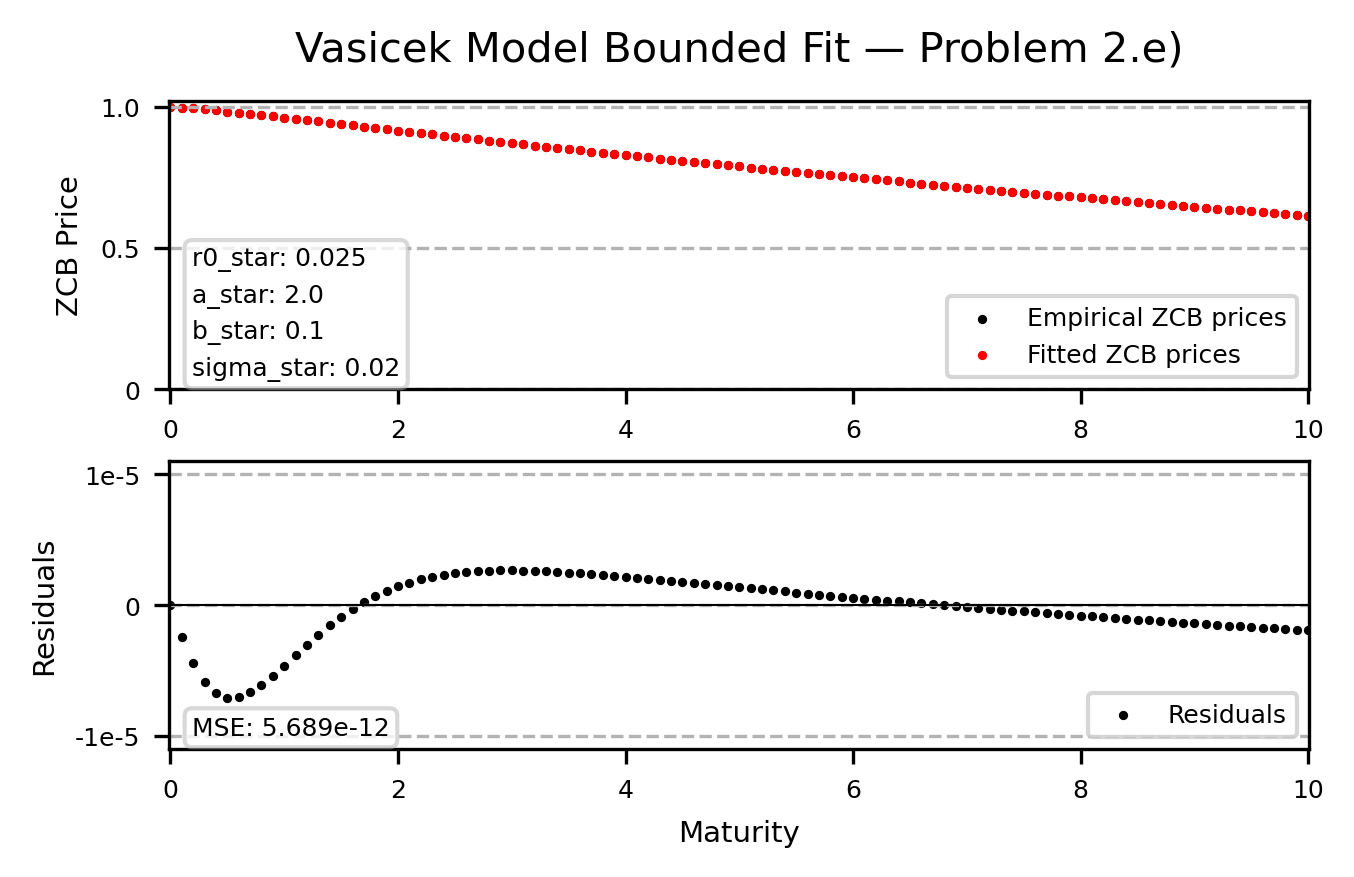

In [40]:
import numpy as np
import fixed_income_derivatives_E2025 as fid
import matplotlib.pyplot as plt
from scipy.optimize import minimize

T = np.arange(0, 10.1, 0.1)

r0_true = 0.025
a_true = 2.0
b_true = 0.10
sigma_true = 0.02

p_star = fid.zcb_price_vasicek(r0_true, a_true, b_true, sigma_true, T)

def fit_vasicek_price_obj(param, p_star, T, scaling=1.0):
    r0, a, b, sigma = param
    p_fit = fid.zcb_price_vasicek(r0, a, b, sigma, T)
    sse = np.sum(scaling * (p_fit - p_star)**2)
    return sse

bounds = [
    (0.0, 0.1),
    (0.0, 10.0),
    (0.0, 0.2),
    (0.0, 0.1)
]

param_0 = (0.03, 1.8, 0.12, 0.03)

result = minimize(
    fit_vasicek_price_obj,
    param_0,
    method="trust-constr",
    bounds=bounds,
    args=(p_star, T),
    options={"verbose": 1}
)

r0_hat, a_hat, b_hat, sigma_hat = result.x

p_hat = fid.zcb_price_vasicek(r0_hat, a_hat, b_hat, sigma_hat, T)

residuals = p_hat - p_star
mse = np.mean(residuals**2)

idx = np.argsort(T)
T_sorted = T[idx]
p_star_sorted = p_star[idx]
p_hat_sorted = p_hat[idx]
residuals_sorted = residuals[idx]

max_abs_residual = np.max(np.abs(residuals_sorted))

print(f"r0_hat: {r0_hat:.6f}, a_hat: {a_hat:.6f}, b_hat: {b_hat:.6f}, sigma_hat: {sigma_hat:.6f}")
print(f"MSE: {mse:.6e}")

fig = plt.figure(constrained_layout=False, dpi=300, figsize=(5,3))
fig.suptitle("Vasicek Model Bounded Fit — Problem 2.e)", fontsize=10)
gs = fig.add_gridspec(nrows=2, ncols=1, left=0.12, bottom=0.18, right=0.88, top=0.90, hspace=0.25)

ax = fig.add_subplot(gs[0,0])
xticks = [0, 2, 4, 6, 8, 10]
ax.set_xticks(xticks)
ax.set_xticklabels(xticks, fontsize=6)
ax.set_xlim([xticks[0]-0.01, xticks[-1]+0.01])
yticks = [0, 0.5, 1.0]
ax.set_yticks(yticks)
ax.set_yticklabels(yticks, fontsize=6)
ax.set_ylim([0, 1.02])
plt.grid(axis='y', which='major', color=(0.7,0.7,0.7,0), linestyle='--')
ax.set_ylabel("ZCB Price", fontsize=7)
ax.scatter(T_sorted, p_star_sorted, s=6, color='black', marker='.', label="Empirical ZCB prices")
ax.scatter(T_sorted, p_hat_sorted, s=6, color='red', marker='.', label="Fitted ZCB prices")
bbox = {"facecolor": (1,1,1,0.8), "edgecolor": (0.7,0.7,0.7,0.5), "boxstyle": "Round"}
ax.text(0.02, 0.05, 
        f"r0_star: {r0_true:.3f}\n"
        f"a_star: {a_true}\n"
        f"b_star: {b_true}\n"
        f"sigma_star: {sigma_true}", 
        transform=ax.transAxes, fontsize=6, bbox=bbox, linespacing=1.6)
ax.legend(loc="lower right", fontsize=6)

ax = fig.add_subplot(gs[1,0])
ax.set_xticks(xticks)
ax.set_xticklabels(xticks, fontsize=6)
ax.set_xlim([xticks[0]-0.01, xticks[-1]+0.01])
yticks = [-1e-5, 0, 1e-5]
ax.set_yticks(yticks)
ax.set_yticklabels(["-1e-5", "0", "1e-5"], fontsize=6)
ax.set_ylim([-1.1e-5, 1.1e-5])
plt.grid(axis='y', which='major', color=(0.7,0.7,0.7,0), linestyle='--')
ax.set_xlabel("Maturity", fontsize=7)
ax.set_ylabel("Residuals", fontsize=7)
ax.scatter(T_sorted, residuals_sorted, s=6, color='black', marker='.', label="Residuals")
ax.axhline(0, color='black', linewidth=0.5)
ax.text(0.02, 0.05, f"MSE: {mse:.3e}", transform=ax.transAxes, fontsize=6, bbox=bbox)
ax.legend(loc="lower right", fontsize=6)

plt.show()

Interpretation: When doing a bounded fit but setting the bounds such that the true parameter values are inside the
bounds, the algorithm does indeed recover the true parameter values and results in a near perfect
fit as illustrated.

---

### 2.f) Bounded Optimization (True Parameters OUTSIDE the Bounds)

#### Purpose
Investigate what happens when we impose parameter bounds that exclude the true parameter values. Bounds: $0 ≤ r ≤ 0.1, 0 ≤ a ≤ 1.8, 0 ≤ b ≤ 0.08, 0 ≤ σ ≤ 0.1$. Since a_true = 2.0 and b_true = 0.10 lie outside these bounds, we examine where the optimizer converges.



`gtol` termination condition is satisfied.
Number of iterations: 45, function evaluations: 180, CG iterations: 66, optimality: 7.11e-09, constraint violation: 0.00e+00, execution time: 0.075 s.
r0_hat: 0.029195, a_hat: 1.569574, b_hat: 0.079425, sigma_hat: 0.052502
MSE: 5.778040e-08


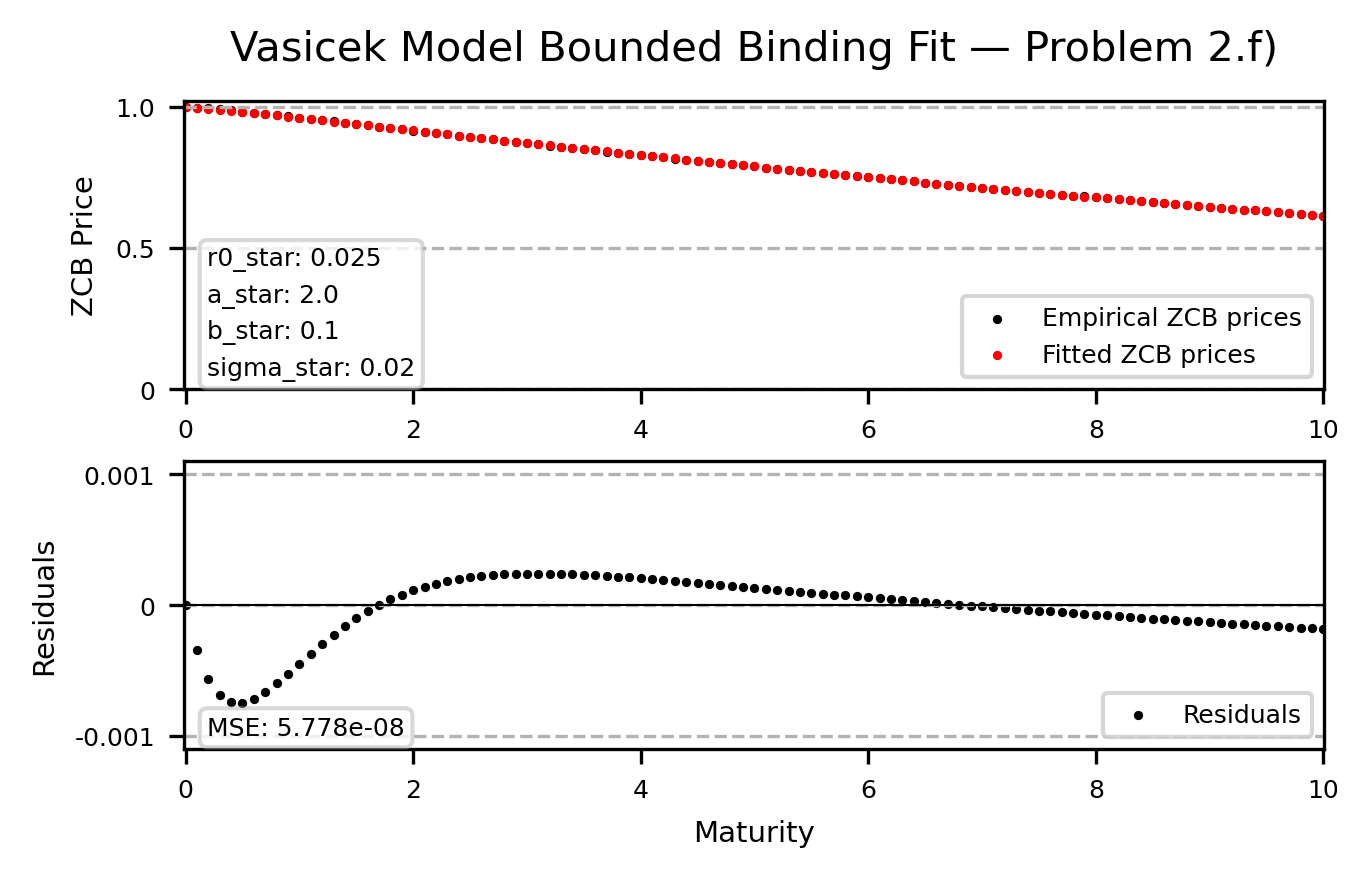

In [41]:
T = np.arange(0, 10.1, 0.1)

r0_true = 0.025
a_true = 2.0
b_true = 0.10
sigma_true = 0.02

p_star = fid.zcb_price_vasicek(r0_true, a_true, b_true, sigma_true, T)

def fit_vasicek_price_obj(param, p_star, T, scaling=1.0):
    r0, a, b, sigma = param
    p_fit = fid.zcb_price_vasicek(r0, a, b, sigma, T)
    sse = np.sum(scaling * (p_fit - p_star)**2)
    return sse

bounds = [
    (0.0, 0.1),
    (0.0, 1.8),
    (0.0, 0.08),
    (0.0, 0.1)
]

param_0 = (0.03, 1.5, 0.07, 0.03)

result = minimize(
    fit_vasicek_price_obj,
    param_0,
    method="trust-constr",
    bounds=bounds,
    args=(p_star, T),
    options={"verbose": 1}
)

r0_hat, a_hat, b_hat, sigma_hat = result.x

p_hat = fid.zcb_price_vasicek(r0_hat, a_hat, b_hat, sigma_hat, T)

residuals = p_hat - p_star
mse = np.mean(residuals**2)

idx = np.argsort(T)
T_sorted = T[idx]
p_star_sorted = p_star[idx]
p_hat_sorted = p_hat[idx]
residuals_sorted = residuals[idx]

print(f"r0_hat: {r0_hat:.6f}, a_hat: {a_hat:.6f}, b_hat: {b_hat:.6f}, sigma_hat: {sigma_hat:.6f}")
print(f"MSE: {mse:.6e}")

fig = plt.figure(constrained_layout=False, dpi=300, figsize=(5,3))
fig.suptitle("Vasicek Model Bounded Binding Fit — Problem 2.f)", fontsize=10)
gs = fig.add_gridspec(nrows=2, ncols=1, left=0.12, bottom=0.18, right=0.88, top=0.90, hspace=0.25)

ax = fig.add_subplot(gs[0,0])
xticks = [0, 2, 4, 6, 8, 10]
ax.set_xticks(xticks)
ax.set_xticklabels(xticks, fontsize=6)
ax.set_xlim([xticks[0]-0.01, xticks[-1]+0.01])
yticks = [0, 0.5, 1.0]
ax.set_yticks(yticks)
ax.set_yticklabels(yticks, fontsize=6)
ax.set_ylim([0, 1.02])
plt.grid(axis='y', which='major', color=(0.7,0.7,0.7,0), linestyle='--')
ax.set_ylabel("ZCB Price", fontsize=7)
ax.scatter(T_sorted, p_star_sorted, s=6, color='black', marker='.', label="Empirical ZCB prices")
ax.scatter(T_sorted, p_hat_sorted, s=6, color='red', marker='.', label="Fitted ZCB prices")
bbox = {"facecolor": (1,1,1,0.8), "edgecolor": (0.7,0.7,0.7,0.5), "boxstyle": "Round"}
ax.text(0.02, 0.05, 
        f"r0_star: {r0_true:.3f}\n"
        f"a_star: {a_true}\n"
        f"b_star: {b_true}\n"
        f"sigma_star: {sigma_true}", 
        transform=ax.transAxes, fontsize=6, bbox=bbox, linespacing=1.6)
ax.legend(loc="lower right", fontsize=6)

ax = fig.add_subplot(gs[1,0])
ax.set_xticks(xticks)
ax.set_xticklabels(xticks, fontsize=6)
ax.set_xlim([xticks[0]-0.01, xticks[-1]+0.01])
yticks = [-0.001, 0, 0.001]
ax.set_yticks(yticks)
ax.set_yticklabels(["-0.001", "0", "0.001"], fontsize=6)
ax.set_ylim([-0.0011, 0.0011])
plt.grid(axis='y', which='major', color=(0.7,0.7,0.7,0), linestyle='--')
ax.set_xlabel("Maturity", fontsize=7)
ax.set_ylabel("Residuals", fontsize=7)
ax.scatter(T_sorted, residuals_sorted, s=6, color='black', marker='.', label="Residuals")
ax.axhline(0, color='black', linewidth=0.5)
ax.text(0.02, 0.05, f"MSE: {mse:.3e}", transform=ax.transAxes, fontsize=6, bbox=bbox)
ax.legend(loc="lower right", fontsize=6)

plt.show()

#### Interpretation
Performing a bounded fit where the true parameter values are outside the bounds results in a poorer
fit but the true parameter values are not far outside the bounds and the fit is, in this case at least,
still pretty decent.

---

### 2.g) - Non-linear Constraint


Purpose: We now learn to add non-linear constraints to the optimization. We use the same wide bounds as in 2.e), but add the requirement 2ab ≥ σ². This constraint ensures the model has good mathematical properties.

`gtol` termination condition is satisfied.
Number of iterations: 99, function evaluations: 705, CG iterations: 283, optimality: 2.38e-09, constraint violation: 0.00e+00, execution time: 0.21 s.
r0_hat: 0.025024, a_hat: 1.992871, b_hat: 0.099861, sigma_hat: 0.035456
MSE: 4.837042e-12
Constraint 2ab - sigma^2: 0.396763


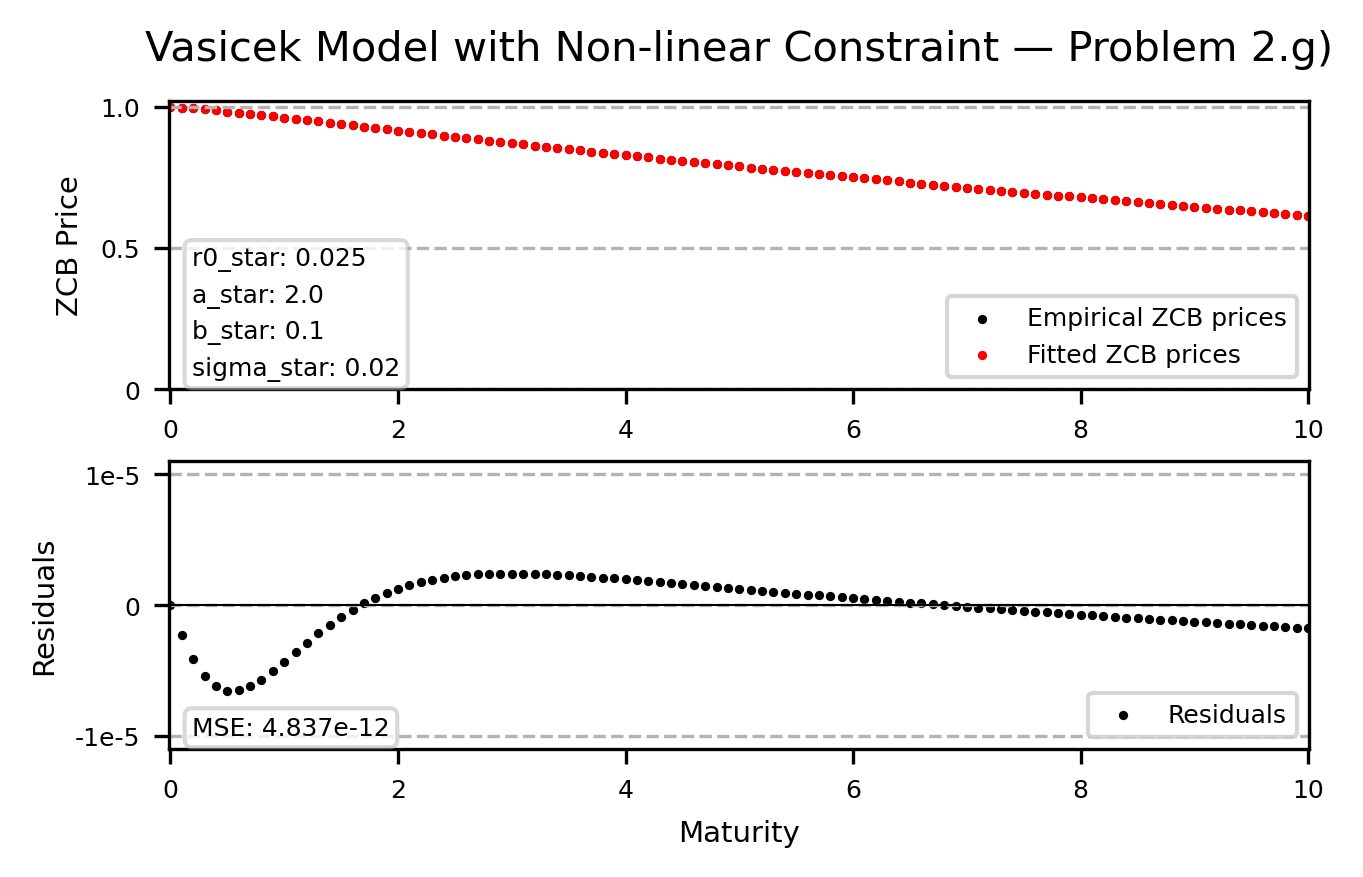

In [42]:
p_star = fid.zcb_price_vasicek(r0_true, a_true, b_true, sigma_true, T)

def fit_vasicek_price_obj(param, p_star, T, scaling=1.0):
    r0, a, b, sigma = param
    p_fit = fid.zcb_price_vasicek(r0, a, b, sigma, T)
    sse = np.sum(scaling * (p_fit - p_star)**2)
    return sse

def constraint_fun(param):
    r0, a, b, sigma = param
    return 2 * a * b - sigma**2

bounds = [
    (0.0, 0.1),
    (0.0, 10.0),
    (0.0, 0.2),
    (0.0, 0.1)
]

nonlinear_constraint = NonlinearConstraint(constraint_fun, 0, np.inf)

param_0 = (0.03, 1.8, 0.12, 0.03)

result = minimize(
    fit_vasicek_price_obj,
    param_0,
    method="trust-constr",
    bounds=bounds,
    constraints=[nonlinear_constraint],
    args=(p_star, T),
    options={"verbose": 1}
)

r0_hat, a_hat, b_hat, sigma_hat = result.x

p_hat = fid.zcb_price_vasicek(r0_hat, a_hat, b_hat, sigma_hat, T)

residuals = p_hat - p_star
mse = np.mean(residuals**2)

idx = np.argsort(T)
T_sorted = T[idx]
p_star_sorted = p_star[idx]
p_hat_sorted = p_hat[idx]
residuals_sorted = residuals[idx]

constraint_value = 2 * a_hat * b_hat - sigma_hat**2

print(f"r0_hat: {r0_hat:.6f}, a_hat: {a_hat:.6f}, b_hat: {b_hat:.6f}, sigma_hat: {sigma_hat:.6f}")
print(f"MSE: {mse:.6e}")
print(f"Constraint 2ab - sigma^2: {constraint_value:.6f}")

fig = plt.figure(constrained_layout=False, dpi=300, figsize=(5,3))
fig.suptitle("Vasicek Model with Non-linear Constraint — Problem 2.g)", fontsize=10)
gs = fig.add_gridspec(nrows=2, ncols=1, left=0.12, bottom=0.18, right=0.88, top=0.90, hspace=0.25)

ax = fig.add_subplot(gs[0,0])
xticks = [0, 2, 4, 6, 8, 10]
ax.set_xticks(xticks)
ax.set_xticklabels(xticks, fontsize=6)
ax.set_xlim([xticks[0]-0.01, xticks[-1]+0.01])
yticks = [0, 0.5, 1.0]
ax.set_yticks(yticks)
ax.set_yticklabels(yticks, fontsize=6)
ax.set_ylim([0, 1.02])
plt.grid(axis='y', which='major', color=(0.7,0.7,0.7,0), linestyle='--')
ax.set_ylabel("ZCB Price", fontsize=7)
ax.scatter(T_sorted, p_star_sorted, s=6, color='black', marker='.', label="Empirical ZCB prices")
ax.scatter(T_sorted, p_hat_sorted, s=6, color='red', marker='.', label="Fitted ZCB prices")
bbox = {"facecolor": (1,1,1,0.8), "edgecolor": (0.7,0.7,0.7,0.5), "boxstyle": "Round"}
ax.text(0.02, 0.05, f"r0_star: {r0_true:.3f}\na_star: {a_true}\nb_star: {b_true}\nsigma_star: {sigma_true}", transform=ax.transAxes, fontsize=6, bbox=bbox, linespacing=1.6)
ax.legend(loc="lower right", fontsize=6)

ax = fig.add_subplot(gs[1,0])
ax.set_xticks(xticks)
ax.set_xticklabels(xticks, fontsize=6)
ax.set_xlim([xticks[0]-0.01, xticks[-1]+0.01])
yticks = [-1e-5, 0, 1e-5]
ax.set_yticks(yticks)
ax.set_yticklabels(["-1e-5", "0", "1e-5"], fontsize=6)
ax.set_ylim([-1.1e-5, 1.1e-5])
plt.grid(axis='y', which='major', color=(0.7,0.7,0.7,0), linestyle='--')
ax.set_xlabel("Maturity", fontsize=7)
ax.set_ylabel("Residuals", fontsize=7)
ax.scatter(T_sorted, residuals_sorted, s=6, color='black', marker='.', label="Residuals")
ax.axhline(0, color='black', linewidth=0.5)
ax.text(0.02, 0.05, f"MSE: {mse:.3e}", transform=ax.transAxes, fontsize=6, bbox=bbox)
ax.legend(loc="lower right", fontsize=6)

plt.show()

*Interpretation: Imposing the suggested non-linear constraint and performing the fit once again results in a perfect
fit as illustrated in the plot below which is of course due to the fact that the true parameters are
consistent with this non-linear constraint*

The conclusion is that economically motivated constraints can be added without degrading the fit, as long as the market data actually satisfies the condition. The constraint functions as a safety mechanism keeping parameters within economically meaningful regions.